# Анализ данных и предобработка

## Выгрузка данных из БД

In [1]:
import pandas as pd

In [2]:
user = pd.read_sql(
    """
    SELECT * FROM public.user_data
    """,
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

In [8]:
# Взглянем на данные по пользователям
user.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [9]:
user.shape

(163205, 8)

In [10]:
post_text_df = pd.read_sql(
    """SELECT * FROM public.post_text_df""",
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

In [11]:
# Посмотрим какую информацию о постах содержит таблица post_text_df
post_text_df.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [13]:
post_text_df.shape

(7023, 3)

Выгружать таблицу feed_data целиком просто не хватит памяти, ограничимся 1.5 млн записей

In [14]:
feed_data = pd.read_sql(
    """SELECT * FROM public.feed_data LIMIT 1500000""",
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

In [15]:
feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-10-23 13:15:13,64520,1239,view,0
1,2021-10-23 13:16:12,64520,1090,view,0
2,2021-10-23 13:18:29,64520,1366,view,0
3,2021-10-23 13:20:03,64520,1205,view,0
4,2021-10-23 13:20:15,64520,280,view,0


In [17]:
# Необходимо определиться что использовать за таргет при обучении модели, смущает дублидорование целевого значения в колонках action
# и target
feed_data[feed_data['action']=='like']

,timestamp,user_id,post_id,action,target
15,2021-10-27 06:11:25,64520,3508,like,0
34,2021-10-27 06:41:35,64520,3587,like,0
42,2021-11-03 20:13:03,64520,6833,like,0
49,2021-11-03 20:24:29,64520,1398,like,0
76,2021-11-05 22:44:43,64520,2592,like,0
...,...,...,...,...,...
1499919,2021-11-24 22:20:45,71080,345,like,0
1499921,2021-11-24 22:23:01,71080,1904,like,0
1499935,2021-11-24 22:43:35,71080,1987,like,0
1499950,2021-11-25 08:22:13,71080,881,like,0


Данные устроены таким образом что объекты где действие like, следуют сразу после объектов тех же самых пар post_id и user_id с действием view и target 1, то есть дублирует данные. Избавимся от дублирования.

In [18]:
feed_data = feed_data[feed_data.action=='view']

# EDA

In [20]:
# Так как таргет определяет колонка target избавимся от колонки action. Объединим таблицы в одну для EDA анализа.
feed_data_eda = feed_data.drop(['action'], axis=1)
df_eda = feed_data_eda.merge(user, how='left', on='user_id')
df_eda = df_eda.merge(post_text_df, how='left', on='post_id')

In [21]:
# Очевидно таргет не зависит от номера поста или юзера, от колонок timestamp и text в явном виде тоже. Вернемся к ним позже.
df_eda = df_eda.drop(['timestamp', 'user_id', 'post_id', 'text'], axis=1)

In [22]:
# Проверим датасет на наличие пропусков
df_eda.isna().sum()

target       0
gender       0
age          0
country      0
city         0
exp_group    0
os           0
source       0
topic        0
dtype: int64

In [23]:
df_eda.head()

,target,gender,age,country,city,exp_group,os,source,topic
0,0,1,35,Russia,Moscow,1,Android,ads,politics
1,0,1,35,Russia,Moscow,1,Android,ads,politics
2,0,1,35,Russia,Moscow,1,Android,ads,politics
3,0,1,35,Russia,Moscow,1,Android,ads,politics
4,0,1,35,Russia,Moscow,1,Android,ads,business


In [25]:
# Посмотрим какие фичи можно обозначить за категориальные для OHE в будущем
df_eda.nunique()

target         2
gender         2
age           55
country       11
city         891
exp_group      5
os             2
source         2
topic          7
dtype: int64

In [26]:
categorical_columns = ['gender','country', 'os', 'source', 'topic', 'exp_group']

In [31]:
### Установим удобные дефолтные настройки matplotlib
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

mlp.rcParams['lines.linewidth'] = 5

mlp.rcParams['xtick.major.size'] = 20
mlp.rcParams['xtick.major.width'] = 5
mlp.rcParams['xtick.labelsize'] = 20
mlp.rcParams['xtick.color'] = '#FF5533'

mlp.rcParams['ytick.major.size'] = 20
mlp.rcParams['ytick.major.width'] = 5
mlp.rcParams['ytick.labelsize'] = 20
mlp.rcParams['ytick.color'] = '#FF5533'

mlp.rcParams['axes.labelsize'] = 20
mlp.rcParams['axes.titlesize'] = 20
mlp.rcParams['axes.titlecolor'] = '#00B050'
mlp.rcParams['axes.labelcolor'] = '#00B050'

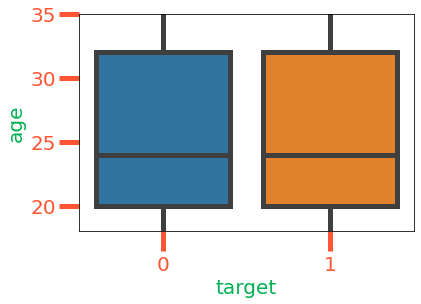

In [32]:
fig = plt.figure()
    
sns.boxplot(y='age', x=df_eda['target'].astype('category'), data=df_eda)

plt.ylim([18,35])
plt.show()

Из боксплотов выше видно что распределение таргетнй переменной не зависит от возраста.

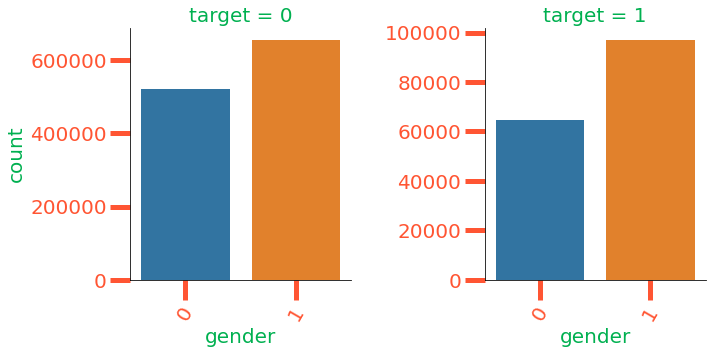

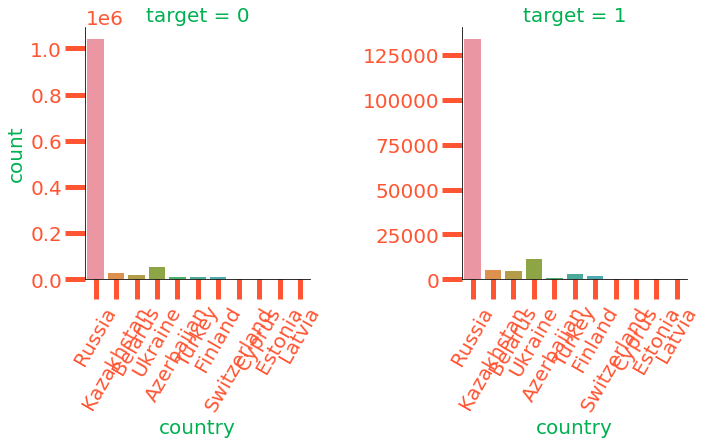

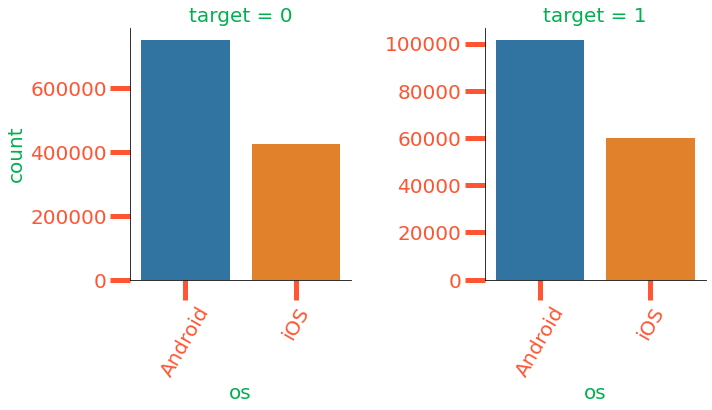

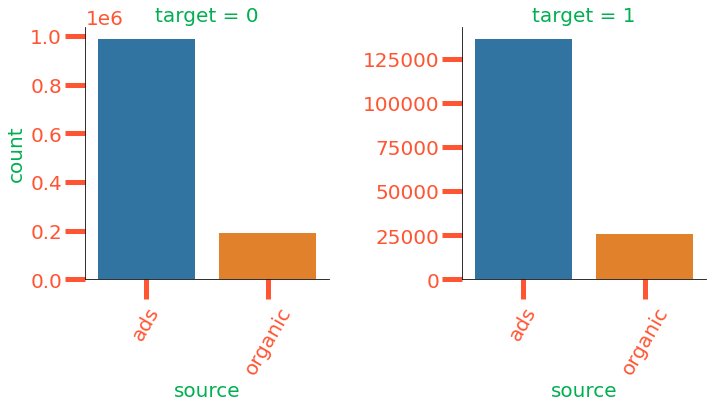

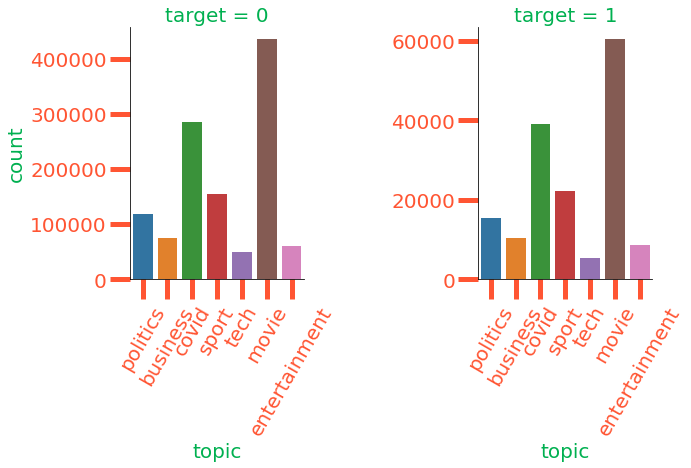

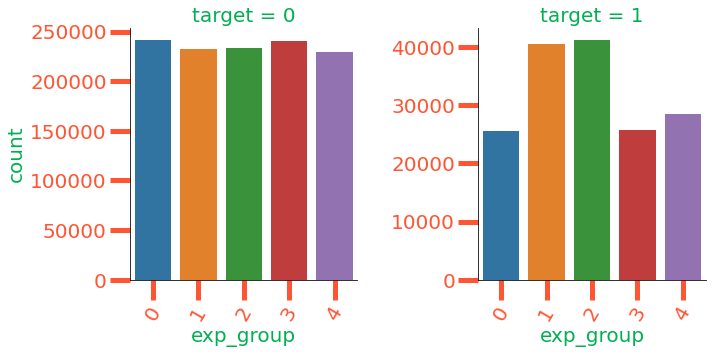

In [33]:
for col in categorical_columns:
    g = sns.catplot(x=col, kind='count', col='target', data=df_eda, sharey=False)
    g.set_xticklabels(rotation=60)

По гистрограммам выше можно сказать что распределение таргетной переменной зависит от таких фичей как exp_group, gender, в меньшей степени от topic и country и совсем не зависит от source и os

In [39]:
# Для оценки влияния колонки city на таргет воспользуемся MTE
mean_target = df_eda.groupby('city')['target'].mean()
df_eda['city'] = df_eda['city'].map(mean_target)

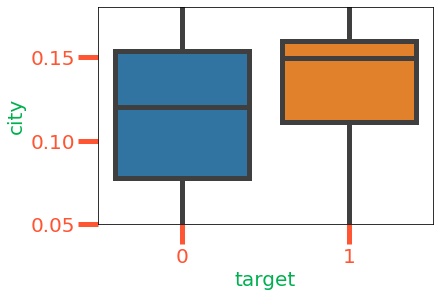

In [40]:
sns.boxplot(y='city', x=df_eda['target'].astype('category'), data=df_eda)
plt.ylim([0.05,0.18])
plt.show()

Видно что значение таргетной переменной сильно зависит от того из какого города пользователь.

# Фичеинжениринг

Для нашего рекомендательного сервиса воспользуемся контентным подходом для генерации рекомендаций. Таким образом нам необходимо построить модель, которая для любой пары(user_id, post_id) будет предсказывать вероятность случится лайк или нет. 

In [41]:
# Как мы выяснили из EDA фичи os и source можно удалить
user = user.drop(['os', 'source'], axis=1)

In [43]:
# Оставим данный набор признаков для user без генерации новых фичей, в надежде что этого будет достаточно.
user.head()

,user_id,gender,age,country,city,exp_group
0,200,1,34,Russia,Degtyarsk,3
1,201,0,37,Russia,Abakan,0
2,202,1,17,Russia,Smolensk,4
3,203,0,18,Russia,Moscow,1
4,204,0,36,Russia,Anzhero-Sudzhensk,3


In [45]:
# С постами сложнее, одного признака topic кажется недостаточно, воспользуемся технологией tf_idf для генерации новых признаков
post_text_df.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [46]:
import re
import string

from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer

wnl = WordNetLemmatizer()

def preprocessing(line, token=wnl):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\n\n', ' ').replace('\n', ' ')
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])
    return line


tfidf = TfidfVectorizer(
    stop_words='english',
    preprocessor=preprocessing
)

In [47]:
tfidf_data = (
    tfidf
    .fit_transform(post_text_df['text'])
    .toarray()
)

tfidf_data

/Users/slava/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  warnings.warn(


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.13273932, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05061394, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [48]:
tfidf_data = pd.DataFrame(
    tfidf_data,
    index=post_text_df.post_id,
    columns=tfidf.get_feature_names_out()
)

tfidf_data

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,𝓫𝓮,𝓫𝓮𝓽𝓽𝓮𝓻,𝓬𝓸𝓾𝓻𝓽𝓼,𝓱𝓮𝓪𝓻𝓲𝓷𝓰,𝓶𝓪𝔂,𝓹𝓱𝔂𝓼𝓲𝓬𝓪𝓵,𝓼𝓸𝓸𝓷𝓮𝓻,𝓼𝓾𝓫𝓸𝓻𝓭𝓲𝓷𝓪𝓽𝓮,𝓽𝓱𝓮,𝓽𝓸
post_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.132739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.050614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7315,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7316,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7317,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# Попробуем кластеризовать тексты
from sklearn.decomposition import PCA

centered = tfidf_data - tfidf_data.mean()

pca = PCA(n_components=20)
pca_decomp = pca.fit_transform(centered)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(pca_decomp)

post_text_df['TextCluster'] = kmeans.labels_

dists_columns = ['DistanceTo1thCluster',
                 'DistanceTo2thCluster',
                 'DistanceTo3thCluster',
                 'DistanceTo4thCluster',
                 'DistanceTo5thCluster',
                 'DistanceTo6thCluster',
                 'DistanceTo7thCluster',
                 'DistanceTo8thCluster',
                 'DistanceTo9thCluster',
                 'DistanceTo10thCluster',
                 'DistanceTo11thCluster',
                 'DistanceTo12thCluster',
                 'DistanceTo13thCluster',
                 'DistanceTo14thCluster',
                 'DistanceTo15thCluster']

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

dists_df.head()

,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,0.510937,0.463388,0.477196,0.440136,0.539453,0.527213,0.144610,0.500084,0.506029,0.440414,0.453197,0.436787,0.389814,0.526043,0.543879
1,0.379620,0.322709,0.339244,0.286187,0.435316,0.262580,0.252322,0.372206,0.411457,0.286531,0.296852,0.290389,0.158480,0.409428,0.437518
2,0.418097,0.351655,0.360656,0.326288,0.471878,0.471842,0.121398,0.387376,0.420059,0.311216,0.344636,0.313557,0.230770,0.430786,0.457224
3,0.378975,0.291359,0.320117,0.286273,0.436009,0.424296,0.222261,0.351165,0.400542,0.261629,0.291082,0.256116,0.146854,0.386472,0.424123
4,0.346142,0.231365,0.259613,0.217930,0.393798,0.386695,0.285185,0.295416,0.351093,0.178211,0.243636,0.161555,0.090319,0.343334,0.418218


In [50]:
post_text_df = pd.concat((post_text_df,dists_df), axis=1)

post_text_df.head()

,post_id,text,topic,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,6,0.510937,0.463388,0.477196,0.440136,0.539453,0.527213,0.144610,0.500084,0.506029,0.440414,0.453197,0.436787,0.389814,0.526043,0.543879
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,12,0.379620,0.322709,0.339244,0.286187,0.435316,0.262580,0.252322,0.372206,0.411457,0.286531,0.296852,0.290389,0.158480,0.409428,0.437518
2,3,Asian quake hits European shares\n\nShares in ...,business,6,0.418097,0.351655,0.360656,0.326288,0.471878,0.471842,0.121398,0.387376,0.420059,0.311216,0.344636,0.313557,0.230770,0.430786,0.457224
3,4,India power shares jump on debut\n\nShares in ...,business,12,0.378975,0.291359,0.320117,0.286273,0.436009,0.424296,0.222261,0.351165,0.400542,0.261629,0.291082,0.256116,0.146854,0.386472,0.424123
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,12,0.346142,0.231365,0.259613,0.217930,0.393798,0.386695,0.285185,0.295416,0.351093,0.178211,0.243636,0.161555,0.090319,0.343334,0.418218


Воспроизведем датафрейм со всеми новыми фичами

In [52]:
df = pd.merge(feed_data,
              post_text_df,
              on='post_id',
              how='left')

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,2021-10-23 13:15:13,64520,1239,view,0,Woolf murder sentence rethink\n\nPlans to give...,politics,12,0.384872,0.283117,...,0.373012,0.325358,0.329368,0.346640,0.226695,0.294492,0.220901,0.140059,0.381626,0.453338
1,2021-10-23 13:16:12,64520,1090,view,0,Schools to take part in mock poll\n\nRecord nu...,politics,5,0.406275,0.318163,...,0.223297,0.367154,0.367006,0.404395,0.274326,0.327307,0.262975,0.244323,0.402845,0.467818
2,2021-10-23 13:18:29,64520,1366,view,0,"Prime ministers questions\n\nSo who, if anyone...",politics,5,0.509090,0.444713,...,0.106757,0.482462,0.455233,0.493490,0.397515,0.454613,0.413562,0.358614,0.513179,0.580480
3,2021-10-23 13:20:03,64520,1205,view,0,Jack Cunningham to stand down\n\nVeteran Labou...,politics,5,0.494363,0.423632,...,0.140679,0.434925,0.454834,0.497967,0.388136,0.441776,0.389135,0.323522,0.496036,0.556448
4,2021-10-23 13:20:15,64520,280,view,0,Worldcom director ends evidence\n\nThe former ...,business,12,0.468148,0.380805,...,0.382426,0.400096,0.413411,0.477250,0.339674,0.373505,0.342441,0.250941,0.459236,0.497398


In [53]:
df = pd.merge(df,
              user,
              on='user_id',
              how='left')

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,...,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,gender,age,country,city,exp_group
0,2021-10-23 13:15:13,64520,1239,view,0,Woolf murder sentence rethink\n\nPlans to give...,politics,12,0.384872,0.283117,...,0.294492,0.220901,0.140059,0.381626,0.453338,1,35,Russia,Moscow,1
1,2021-10-23 13:16:12,64520,1090,view,0,Schools to take part in mock poll\n\nRecord nu...,politics,5,0.406275,0.318163,...,0.327307,0.262975,0.244323,0.402845,0.467818,1,35,Russia,Moscow,1
2,2021-10-23 13:18:29,64520,1366,view,0,"Prime ministers questions\n\nSo who, if anyone...",politics,5,0.509090,0.444713,...,0.454613,0.413562,0.358614,0.513179,0.580480,1,35,Russia,Moscow,1
3,2021-10-23 13:20:03,64520,1205,view,0,Jack Cunningham to stand down\n\nVeteran Labou...,politics,5,0.494363,0.423632,...,0.441776,0.389135,0.323522,0.496036,0.556448,1,35,Russia,Moscow,1
4,2021-10-23 13:20:15,64520,280,view,0,Worldcom director ends evidence\n\nThe former ...,business,12,0.468148,0.380805,...,0.373505,0.342441,0.250941,0.459236,0.497398,1,35,Russia,Moscow,1


Можно предположить что таргетная переменная зависит от вермени просмотра поста юзером, извлечем из колонки timestamp еще пару фичей

In [54]:
df['hour'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.hour)
df['month'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.month)

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,...,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,gender,age,country,city,exp_group,hour,month
0,2021-10-23 13:15:13,64520,1239,view,0,Woolf murder sentence rethink\n\nPlans to give...,politics,12,0.384872,0.283117,...,0.140059,0.381626,0.453338,1,35,Russia,Moscow,1,13,10
1,2021-10-23 13:16:12,64520,1090,view,0,Schools to take part in mock poll\n\nRecord nu...,politics,5,0.406275,0.318163,...,0.244323,0.402845,0.467818,1,35,Russia,Moscow,1,13,10
2,2021-10-23 13:18:29,64520,1366,view,0,"Prime ministers questions\n\nSo who, if anyone...",politics,5,0.509090,0.444713,...,0.358614,0.513179,0.580480,1,35,Russia,Moscow,1,13,10
3,2021-10-23 13:20:03,64520,1205,view,0,Jack Cunningham to stand down\n\nVeteran Labou...,politics,5,0.494363,0.423632,...,0.323522,0.496036,0.556448,1,35,Russia,Moscow,1,13,10
4,2021-10-23 13:20:15,64520,280,view,0,Worldcom director ends evidence\n\nThe former ...,business,12,0.468148,0.380805,...,0.250941,0.459236,0.497398,1,35,Russia,Moscow,1,13,10


In [59]:
df = df.drop([
#    'timestamp',  ### timestamp пока оставим
    'action',
    'text',
],
    axis=1)

df = df.set_index(['user_id', 'post_id'])

In [60]:
max(df.timestamp), min(df.timestamp)

(Timestamp('2021-12-29 23:39:35'), Timestamp('2021-10-01 06:06:44'))

In [61]:
df_train = df[df.timestamp < '2021-12-15']
df_test = df[df.timestamp >= '2021-12-15']

df_train = df_train.drop('timestamp', axis=1)
df_test = df_test.drop('timestamp', axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']

y_train.shape, y_test.shape

((1121131,), (220929,))

In [62]:
object_cols = [
    'topic', 'TextCluster', 'gender', 'country',
    'city', 'exp_group', 'hour', 'month',
]

In [63]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1121131 entries, (62286, 3885) to (75938, 1394)
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   topic                  1121131 non-null  object 
 1   TextCluster            1121131 non-null  int32  
 2   DistanceTo1thCluster   1121131 non-null  float64
 3   DistanceTo2thCluster   1121131 non-null  float64
 4   DistanceTo3thCluster   1121131 non-null  float64
 5   DistanceTo4thCluster   1121131 non-null  float64
 6   DistanceTo5thCluster   1121131 non-null  float64
 7   DistanceTo6thCluster   1121131 non-null  float64
 8   DistanceTo7thCluster   1121131 non-null  float64
 9   DistanceTo8thCluster   1121131 non-null  float64
 10  DistanceTo9thCluster   1121131 non-null  float64
 11  DistanceTo10thCluster  1121131 non-null  float64
 12  DistanceTo11thCluster  1121131 non-null  float64
 13  DistanceTo12thCluster  1121131 non-null  float64
 14  

# Построение модели

In [64]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier(iterations=100,
                              learning_rate=1,
                              depth=2)

catboost.fit(X_train, y_train, object_cols)

0:	learn: 0.3551022	total: 280ms	remaining: 27.8s
1:	learn: 0.3479485	total: 444ms	remaining: 21.8s
2:	learn: 0.3461957	total: 615ms	remaining: 19.9s
3:	learn: 0.3453615	total: 752ms	remaining: 18.1s
4:	learn: 0.3447732	total: 876ms	remaining: 16.6s
5:	learn: 0.3445829	total: 1.02s	remaining: 16s
6:	learn: 0.3433548	total: 1.15s	remaining: 15.3s
7:	learn: 0.3432867	total: 1.28s	remaining: 14.7s
8:	learn: 0.3432359	total: 1.4s	remaining: 14.2s
9:	learn: 0.3431965	total: 1.52s	remaining: 13.7s
10:	learn: 0.3429311	total: 1.65s	remaining: 13.4s
11:	learn: 0.3428988	total: 1.78s	remaining: 13.1s
12:	learn: 0.3428552	total: 1.91s	remaining: 12.8s
13:	learn: 0.3427972	total: 2.04s	remaining: 12.5s
14:	learn: 0.3427183	total: 2.16s	remaining: 12.3s
15:	learn: 0.3426981	total: 2.3s	remaining: 12.1s
16:	learn: 0.3426449	total: 2.42s	remaining: 11.8s
17:	learn: 0.3426228	total: 2.55s	remaining: 11.6s
18:	learn: 0.3425617	total: 2.67s	remaining: 11.4s
19:	learn: 0.3423624	total: 2.81s	remaining: 

## Оценка обобщающей способности

In [65]:
from sklearn.metrics import roc_auc_score

print(f"Качество на трейне: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.6651056611037182
Качество на тесте: 0.6436265509343402


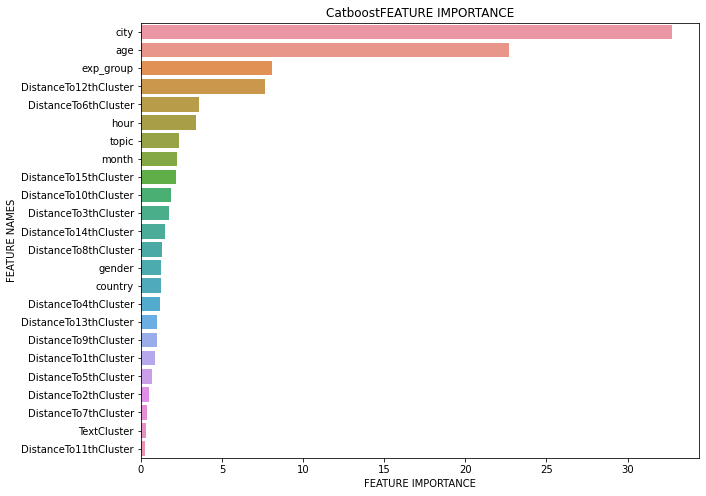

In [66]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(catboost.feature_importances_,X_train.columns,'Catboost')

In [67]:
# Сохраним модель для использования в сервисе
catboost.save_model(
    'catboost_model_ML',
    format="cbm"                  
)

Одно из условий - высокая скорость работы сервиса. Чтобы алгоритм работал не более, чем ~0.5 секунд на 1 запрос, и занимал не более ~4 гб памяти (цифры приблизительные). Для этого при запуске сервиса необходимо подгружать все необходимые фичи и уже после использовать их для ответа на запросы. Таким образом необходимо загрузить в БД сгенерированные нами фичи для постов, чтобы сервис мог подгрузить их и использоваться для ответов на запросы.

In [33]:
from sqlalchemy import create_engine

engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)

In [34]:
post_text_df.to_sql('syvl1526_post_features_lesson_22', con=engine, if_exists='replace', index=False)

23

In [34]:
post_features = pd.read_sql('SELECT * FROM syvl1526_post_features_lesson_22',
                                con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
                                    "postgres.lab.karpov.courses:6432/startml")

In [35]:
post_features

,post_id,text,topic,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8,2.153114,3.209713,3.315933,2.689789,2.031216,3.354790,3.366697,3.269926,1.524006,3.299069,3.152751,3.328958,3.293204,3.623055,1.716174
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,14,2.099521,2.939332,3.182701,2.351207,1.985007,2.972548,3.102073,3.262159,1.905109,2.776830,3.101986,3.156642,3.040610,3.335614,1.151286
2,3,Asian quake hits European shares\n\nShares in ...,business,14,2.201690,3.067036,3.215819,2.740349,2.890282,2.982804,3.290214,3.410616,1.614456,2.776148,3.073328,3.279219,3.108002,3.414121,1.444157
3,4,India power shares jump on debut\n\nShares in ...,business,14,2.610834,3.406561,3.614797,3.243489,3.255605,3.677278,3.938211,3.592189,2.277413,3.560412,3.316584,3.665310,3.527911,2.877233,2.166004
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,8,1.567997,2.613337,2.603911,1.822236,2.734950,2.587180,3.017002,2.588999,1.158517,2.418697,2.759536,2.549493,2.659264,3.083571,1.710517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7314,Although the likeliness of someone focusing on...,movie,2,2.334423,2.762487,1.194172,2.504813,3.154260,1.390073,3.482516,1.749305,3.042485,3.259916,3.073546,1.832850,1.659425,2.318609,2.952777
7019,7316,I give this movie 2 stars purely because of it...,movie,2,2.312294,2.390371,0.684811,2.106351,3.106223,1.680666,3.288762,1.045022,2.853192,3.111540,2.779209,1.600196,1.709912,2.039391,2.950864
7020,7317,I cant believe this film was allowed to be mad...,movie,2,2.634949,2.222740,1.178921,2.266988,3.286906,1.821513,3.362763,1.791694,3.052756,3.014604,2.640013,1.790074,2.131889,2.404646,3.130379
7021,7318,The version I saw of this film was the Blockbu...,movie,7,2.932534,3.126878,1.411033,2.258866,3.397912,1.559684,3.347694,1.025709,3.139847,3.161298,3.345481,1.048071,1.938024,1.894121,3.228782
